<a href="https://colab.research.google.com/github/kevinbgunn/Courses-2/blob/master/BERT_for_Humanists_June_Fine_Tuning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and Fine-Tuning BERT for Classification
## Classfying Goodreads Reviews By Book Genre

By The [BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team
<br></br>

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on Goodreads reviews from the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews?authuser=0) with the goal of predicting the genre of the book being reviewed. The genres include:
- poetry
- comics & graphic
- fantasy & paranormal
- history & biography
- mystery, thriller, & crime
- romance
- young adult  

**Basic steps involved in using BERT and HuggingFace:**
1. Divide your data into training and test sets.
2. Encode your data into a format BERT will understand.
3. Combine your data and labels into datset objects.
4. Load the pre-trained BERT model.
5. Fine-tune the model using your training data.
6. Predict new labels and evaluate performance on your test data.



<br><br>

## **Import necessary Python libraries and modules**

First, we will import necessary Python libraries and modules. These include as `gdown`, for downloading large files from Google Drive (where we will get our UCSD Goodreads reviews), as well as scikit-learn (`sklearn`) and PyTorch (`torch`), for various machine learning tools.

In [ ]:
# Basic Python modules
from collections import defaultdict
import random
import pickle

# For downloading large files from Google Drive
# https://github.com/wkentaro/gdown
import gdown

# For working with gzip files
# https://docs.python.org/3/library/gzip.html
import gzip

# For working with JSON files
import json

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch

# For plotting and data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we will install it with `pip`.

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 2.3MB 9.0MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 
     |████████████████████████████████| 3.3MB 48.0MB/s 


Once `transformers` is installed, we will import modules for `DistilBert`, a *distilled* or smaller version of a BERT model that runs more quickly and uses less computing power. This makes it ideal for those just getting started with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

<br><br>

## **Set parameters and file paths**

In [ ]:
# This is the name of the BERT model that we want to use. 
# We're using DistilBERT to save space (it's a distilled version of the full BERT model), 
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'  

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'       

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'distilbert-reviews-genres'  

<br><br>

## **Load and sample Goodreads data**

In this cell, we create a Python dictionary with each genre and the link to the corresponding UCSD Goodreads review data for that genre on Google Drive.

*If you manually click on any of the URLs, you will be able to download the data for that genre. For example, here's the link for poetry: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO*

In [ ]:
# This is where our target data is hosted on the web. You only need these paths for the book review dataset.

genre_url_dict = {'poetry':                 'https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO',
                  'children':               'https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR',
                  'comics_graphic':         'https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe',
                  'fantasy_paranormal':     'https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X',
                  'history_biography':      'https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9',
                  'mystery_thriller_crime': 'https://drive.google.com/uc?id=1ONpyuv0vrtd6iUEp0-zzkKqwpm3njEqi',
                  'romance':                'https://drive.google.com/uc?id=1NpFsDQKBj_lrTzSASfyKbmkSykzN88wE',
                  'young_adult':            'https://drive.google.com/uc?id=1M5iqCZ8a7rZRtsmY5KQ5rYnP9S0bQJVo'}

Next we loop through this dictionary and use `gdown` to download the Goodreads review data for each genre from Google Drive.

In [ ]:
for _genre, _url in genre_url_dict.items():
  gdown.download(_url, _genre + '.json.gz', quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1FVD3LxJXRc5GrKm97LehLgVGbRfF9TyO
To: /content/poetry.json.gz
49.3MB [00:01, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1908GDMdrhDN7sTaI_FelSHxbwcNM1EzR
To: /content/children.json.gz
172MB [00:02, 78.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V4MLeoEiPQdocCbUHjR_7L9ZmxTufPFe
To: /content/comics_graphic.json.gz
147MB [00:02, 64.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1THnnmE4XSCvMkGOsqapQr2cJI5amKA6X
To: /content/fantasy_paranormal.json.gz
1.26GB [00:15, 80.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDkTzM6zpYU-HGkVAQgsw0dBzik-Zde9
To: /content/history_biography.json.gz
754MB [00:24, 30.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ONpyuv0vrtd6iUEp0-zzkKqwpm3njEqi
To: /content/mystery_thriller_crime.json.gz
610MB [00:18, 33.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NpFsDQKBj_lrTzSASfyKbmkSykzN88wE
To: /content/romance.json.gz
1.30GB

If you click the file browser icon in the left-hand side bar, you should see that these files have now been download.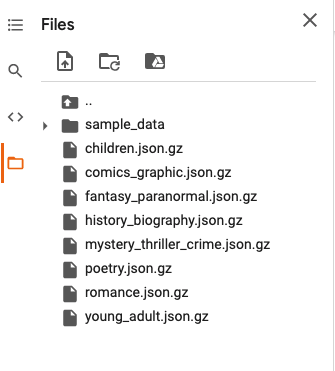 

Next we create a function `load_reviews()`, which will use `gzip` to unzip the downloaded Goodreads review JSON files and `json` to load the JSON files once they're unzipped.

In [ ]:
def load_reviews(file_name,
                 head=None):

    reviews = []
    count = 0

    with gzip.open(file_name) as file:
        for line in file:

            d = json.loads(line)
            count += 1

            _book_id = d['book_id']

            reviews.append(d['review_text'])

            # Break if we reach the Nth line
            if (head is not None) and (count > head):
                break

    return reviews

Now we apply the `load_reviews()` function. For each genre, we load and unzip the corresponding `.json.gz` file, e.g., `poetry.json.gz`, then we randomly sample 2000 Goodreads reviews and make a dictionary `genre_reviews_dict` of all these reviews.

In [ ]:
genres = ['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult']
genre_reviews_dict = {}

for _genre in genres:
  print('Loading ' + _genre + '.json.gz')

  _reviews = load_reviews(_genre + '.json.gz')
  genre_reviews_dict[_genre] = random.sample(_reviews, 2000)

Loading poetry.json.gz
Loading children.json.gz
Loading comics_graphic.json.gz
Loading fantasy_paranormal.json.gz
Loading history_biography.json.gz
Loading mystery_thriller_crime.json.gz
Loading romance.json.gz
Loading young_adult.json.gz


Let's preview a couple of the key-value pairs in `genre_reviews_dict`

In [ ]:
 for _genre, _reviews in genre_reviews_dict.items():
    print(_genre)
    print(random.sample(_reviews, 1)[0])

poetry
Creme de la creme! 
 For men may come and men may go, 
 But I go on forever. 
 A poem that is almost lyrical to the sound the flowing water makes as it winds down the lanes, up and below the pebbles, rafting its way to its destiny. 
 The very purest form of poetry.
children
When I was in 7th grade, our English class was broken down into reading groups. The gifted kids (of which I was one) read Animal Farm. I had read Animal Farm and so got stuck reading A Tale of Two Cities by myself. I tell this story because the only thing I remember about the books other groups read is that one was The Dark is Rising and I remember thinking that it sounded like a really cool book. 
 Then I neverror read it. 
 I always meant to, but there were other things like school, travel and college that got in the way. So I finally decided it was high time I read it. 
 This. Book. Is. Great! Starting out the writing style reminded me of the beginning of A Wrinkle in Time. There was also moments that remi

Here we use `pickle` to save this Python dictionary to a `.pickle` file so we can easily load it later.

*The `pickle` module allows you to save and load Python objects like lists and dictionaries.*

In [ ]:
pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
# genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

<br><br>

## **Split the data into training and test sets**

When training a machine learning model, it is necessary to split your training data into two parts: a "training" set and a "test" set.

We will train our BERT model on the "training" set of Goodreads reviews and then we will evaluate how well it is performing by running it on the "test" set of Goodreads reviews that the model has never seen before.

Normally, to tune the hyperparameters, you should also create a "validation" set for tuning, and only use the "test" set once, at the end of all tuning. For simplicity, in this tutorial, we will only using a training and test set.

In [ ]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

  _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.
  
  for _review in _reviews[:800]:
    train_texts.append(_review)
    train_labels.append(_genre)
  for _review in _reviews[800:]:
    test_texts.append(_review)
    test_labels.append(_genre)

Show how many Goodreads reviews and labels we have in each category: 6400 training reviews, 6400 training labels (genres), 1600 test reviews, 1600 test labels (genre)

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(6400, 6400, 1600, 1600)

Here's an example of a training label and review:

In [ ]:
train_labels[0], train_texts[0]

('poetry',
 "I'll be honest--I've never read it straight from start to finish. But I've had enough pieces of this one through various courses that I feel I've got a decent handle of it.")

<br><br>

## **Run a baseline model (logistic regression)**

Here we train and evaluate a simple TF-IDF baseline model using logistic regression.

We find better-than-random performance, even for a very small dataset. We'll see whether BERT can beat this good baseline!

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

We train a logistic regression model from scikit-learn on the Goodreads training data, and then we use the trained model to make predictions on our Goodreads review test set.

In [ ]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

We can use scikit-learn's `classification_report` function to evaluate how well the logistic regression model's predictions match up with the true labels for the Goodreads reviews. 

Importantly, we can see that our average scores are above random performance (we have 8 classes, so random performance would be ~0.2). 

In [ ]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.63      0.62      0.63       200
        comics_graphic       0.60      0.62      0.61       200
    fantasy_paranormal       0.34      0.26      0.29       200
     history_biography       0.54      0.46      0.49       200
mystery_thriller_crime       0.50      0.48      0.49       200
                poetry       0.60      0.79      0.68       200
               romance       0.45      0.48      0.47       200
           young_adult       0.38      0.38      0.38       200

              accuracy                           0.51      1600
             macro avg       0.50      0.51      0.50      1600
          weighted avg       0.50      0.51      0.50      1600



<br><br>

## **Encode data for BERT**

We're going to transform our texts and labels into a format that BERT (via Huggingface and PyTorch) will understand. This is called *encoding* the data.

Here are the steps we need to follow:

1. The labels&mdash;in this case, Goodreads genres&mdash;need to be turned into integers rather than strings.

2. The texts&mdash;in this case, Goodreads reviews&mdash;need to be truncated if they're more than 512 tokens or padded if they're fewer than 512 tokens. The tokens, or words in the texts, also need to be separated into "word pieces" and matched to their embedding vectors.

3. We need to add special tokens to help BERT:

| BERT special token | Explanation |
| --------------| ---------|
| [CLS] | Start token of every document. |
| [SEP] | Separator between each sentence |
| [PAD] | Padding at the end of the document as many times as necessary, up to 512 tokens |
|  &#35;&#35; | Start of a "word piece" |




Here we will load `DistilBertTokenizerFast` from the HuggingFace library, which will do all the work of encoding the texts for us. The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

Here we will create a map of our labels, or Goodreads genres, to integer keys. We take the unique labels, and then we make a dictionary that associates each label/tag with an integer.

**Note:** HuggingFace documentation sometimes refers to "labels" as "tags" but these are the same thing. We use "labels" throughout this notebook for clarity.

In [ ]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['children', 'mystery_thriller_crime', 'romance', 'comics_graphic', 'young_adult', 'history_biography', 'poetry', 'fantasy_paranormal'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

Now let's encode our texts and labels!

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

**Examine a Goodreads review in the training set after encoding**

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

"[CLS] I ' ll be honest - - I ' ve never read it straight from start to finish . But I ' ve had enough pieces of this one through various courses that I feel I ' ve got a decent handle of it . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

**Examine a Goodreads review in the test set after encoding**

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

"[CLS] l ' ` l ##m s ##h ` w ##ry t ##H ##dy ##dan m ##n l ##dy ##wn b ##sh ##k ##l km ##l , f ' n m ##G ##rm b ##b ` D q ##S ##y ' d ##h w ##lm ' s ##t ##T ` m b ` D ##h , w ##m z ##lt ' b ##H ##th ` n s ##h ` w ##r m ##H ##dd lb ` D ##h l ' k ##hr ! l ##G @ ` d ##nn l ##S ##y ' G l t ##nt ##Z ##r s"

**Examine the training labels after encoding**

In [ ]:
set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

**Examine the test labels after encoding**

In [ ]:
set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

<br><br>

## **Make a custom Torch dataset**

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a Goodreads review in the Torch `training_dataset` after encoding**

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

"[CLS] I ' ll be honest - - I ' ve never read it straight from start to finish . But I ' ve had enough pieces of this one through various courses that I feel I ' ve got a decent handle of it . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

**Examine a Goodreads review in the Torch `test_dataset` after encoding**

In [ ]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] f ##y HD ##r @ S ##l ##H ` b ##d l ##S ##b ##w ##r l t ` l ##y ##q s ##wy n t ##sm ` y ##q ` k ##lm ##th l ##sh ` r ##y @ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

<br><br>

## **Load pre-trained BERT model**

Here we load a pre-trained DistilBERT model and send it to CUDA.

**Note:** If you decide to repeat fine-tuning after already running the following cells, make sure that you re-run this cell to re-load the original pre-trained model before fine-tuning again.

In [ ]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier

<br><br>

## **Set the BERT fine-tuning parameters**

These are the arguments we'll set in the HuggingFace TrainingArguments objects, which we'll then pass to the HuggingFace Trainer object. There are many more possible arguments, but here we highlight the basics and some common gotchas.

When training your own model, you should search over these parameters to find the best settings for your particular dataset. You should use a held-out set of validation data for this step.

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler (set lower because of small dataset size) |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

<br><br>

## **Fine-tune the BERT model**

First, we define a custom evaluation function that returns the accuracy. You could modify this function to return precision, recall, F1, and/or other metrics.

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.

**Note:** This is what we've been aiming for this whole time! All the work of tokenizing, creating datasets, and setting the training arguments was for this cell.

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

Time to finally fine-tune! 

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 10 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation ("test") loss, and accuracy (from our `compute_metrics` function).

You should see the loss going down and the accuracy going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.996600,1.705313,0.373125
200,1.584600,1.385085,0.513750
300,1.445400,1.391928,0.489375
400,1.386400,1.374399,0.500000
500,1.101900,1.345952,0.528125
600,1.086500,1.306563,0.540625
700,1.100300,1.269690,0.546875
800,1.102800,1.269377,0.532500
900,0.752600,1.316513,0.546875
1000,0.745900,1.337238,0.553125


TrainOutput(global_step=1200, training_loss=1.141270949045817, metrics={'train_runtime': 1334.6642, 'train_samples_per_second': 0.899, 'total_flos': 646718973542400.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 32768, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -351195136, 'train_mem_gpu_alloc_delta': 790109696, 'train_mem_cpu_peaked_delta': 364605440, 'train_mem_gpu_peaked_delta': 6540809216})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [ ]:
trainer.save_model(cached_model_directory_name)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

<br><br>

## **Evaluate fine-tuned model**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [ ]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.55,
 'eval_loss': 1.3486912250518799,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 723764736,
 'eval_runtime': 28.7647,
 'eval_samples_per_second': 55.624}

But we might want to do more fine-grained analysis of the model, so we extract the predicted labels.

In [ ]:
predicted_results = trainer.predict(test_dataset)

In [ ]:
predicted_results.predictions.shape

(1600, 8)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [ ]:
len(predicted_labels)

1600

In [ ]:
print(classification_report(test_labels, 
                            predicted_labels))

                        precision    recall  f1-score   support

              children       0.64      0.65      0.65       200
        comics_graphic       0.60      0.72      0.66       200
    fantasy_paranormal       0.36      0.32      0.34       200
     history_biography       0.63      0.53      0.57       200
mystery_thriller_crime       0.52      0.60      0.56       200
                poetry       0.74      0.80      0.77       200
               romance       0.49      0.41      0.45       200
           young_adult       0.37      0.37      0.37       200

              accuracy                           0.55      1600
             macro avg       0.55      0.55      0.55      1600
          weighted avg       0.55      0.55      0.55      1600



<br><br>

## **Pull out correct and incorrect classifications for examination**

Let's use our predicted labels for some analysis!

Now that we've fine-tuned and pulled out our predicted labels, the BERT part of this tutorial is done. You can now use the predicted labels in the same way you would use any set of predicted labels from any classification model. We'll show some examples here.

First, let's print out some example predictions that were correct.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: children
REVIEW TEXT: Only David Shannon can write a fun book about lice! 
 Informative and sure to make us all itchy. ...

LABEL: poetry
REVIEW TEXT: Read as 3.5 stars... 
 I found this collection to be excellent - intense, beautiful, sad, uncomforta ...

LABEL: children
REVIEW TEXT: Animals, books, encouragement to read. Positively captivating. Plus wonderful illustration by Marc B ...

LABEL: romance
REVIEW TEXT: loved this just as much as the others ...

LABEL: romance
REVIEW TEXT: OMG!!! This book was awesome, but I have yet to be disappointed by a Colleen Hoover book. I highly r ...

LABEL: history_biography
REVIEW TEXT: A good look at Elizabeth's early life. Weir does so much research that it really brings the time and ...

LABEL: poetry
REVIEW TEXT: Exquisite! Favorite new poetry find of the year. ...

LABEL: poetry
REVIEW TEXT: This book was created as a teaching tool. It includes what are supposed to be some of the most-taugh ...



Now let's print out some misclassifications.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: poetry
PREDICTED LABEL: comics_graphic
REVIEW TEXT: There are tears. ...

TRUE LABEL: mystery_thriller_crime
PREDICTED LABEL: romance
REVIEW TEXT: I feel like I've found a pot of gold at the end of the rainbow with this author. Being a newbie to t ...

TRUE LABEL: comics_graphic
PREDICTED LABEL: children
REVIEW TEXT: I'm talking about these books by Jeffrey Brown. 
 The books have brightly colored pictures that are  ...

TRUE LABEL: young_adult
PREDICTED LABEL: romance
REVIEW TEXT: This unique story is told from the alternating views of Emma and Ben. A delightful blend of suspense ...

TRUE LABEL: romance
PREDICTED LABEL: young_adult
REVIEW TEXT: THE STORY 
 In a country divide by castes it's every girl dream to be a Selected and have the chance ...

TRUE LABEL: young_adult
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: one of those unforgettable books. ...

TRUE LABEL: mystery_thriller_crime
PREDICTED LABEL: history_biography
REVIEW TEXT: Although it could have done 

Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

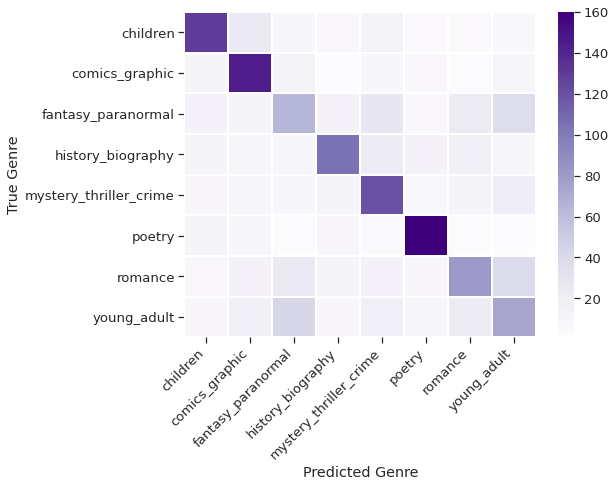

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct labels for each genre. 

Now, let's remove the diagonal from the plot to highlight the misclassifications.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

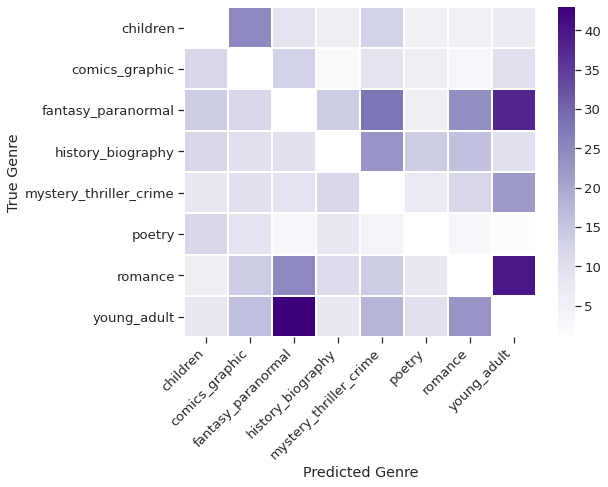

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There's much more you can do with your own dataset and labels! Classification can be used to apply a small set of labels across a big dataset; to explore misclassifications to better understand users; and much more! We hope you'll use this tutorial in all kinds of creative ways.